# Virtual Screening
***

Authors:

- Peter Rüthemann, peter.ruethemann@unibas.ch, 2023
- Manuel Sellner, 2023
- Markus Lill, 2023

## Aim of this notebook

This notebook is used to teach how to prepare, perform, and analyze virtual screenings using the smina docking program.

### References
- Molecular docking:
    - Pagadala _et al._, [_Biophy Rev_ (2017), __9__, 91-102](https://doi.org/10.1007/s12551-016-0247-1)
    - Meng _et al._, [_Curr Comput Aided Drug Des_ (2011), __7__, 2, 146-157](https://doi.org/10.2174/157340911795677602)
    - Gromski _et al._, [_Nat Rev Chem_ (2019), __3__, 119-128](https://doi.org/10.1038/s41570-018-0066-y)
- Docking and scoring function assessment:
    - Warren _et al._, [_J Med Chem_ (2006), __49__, 20, 5912-31](https://doi.org/10.1021/jm050362n)
    - Wang _et al._, [_Phys Chem Chem Phys_ (2016), __18__, 18, 12964-75](https://doi.org/10.1039/c6cp01555g)
    - Koes _et al._, [_J Chem Inf Model_ (2013), __53__, 8, 1893-1904](https://doi.org/10.1021/ci300604z)
    - Kimber _et al._, [_Int J Mol Sci_, (2021), __22__, 9, 1-34](https://doi.org/10.3390/ijms22094435)
    - McNutt _et al._, [_J Cheminform_ (2021), __13__, 43, 13-43](https://doi.org/10.1186/s13321-021-00522-2)
- Visual inspection of docking results: Fischer et al., [_J Med Chem_ (2021), __64__, 5, 2489–2500](https://doi.org/10.1021/acs.jmedchem.0c02227)
- [Other Tutorial](https://chem-workflows.com/articles/2021/09/18/1-molecular-docking/)
- Tools used
    - [OpenBabel](http://openbabel.org/wiki/Main_Page)
    - [Smina](https://sourceforge.net/projects/smina/)
    - [NGLView](http://nglviewer.org/nglview/latest/)
    

## Practical

In this tutorial, we will use the docking software [Smina](https://sourceforge.net/projects/smina/) to perform a virtual sreening for ligands of the androgen receptor. For this task we weill re-use the receptor structure from the Molecular Docking part.

* Smina ([_J Chem Inf Model_ (2013), __53__, 8, 1893-1904](https://doi.org/10.1021/ci300604z)) belongs to the AutoDock family of docking software that requires preparation of protein and ligand prior to docking. 
* After docking, results will be analyzed for their agreement with experimental data.

In [110]:
# import libraries
from pathlib import Path
from os import path, makedirs
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.notebook import tqdm
from openbabel import pybel

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import molplotly
from sklearn.metrics import roc_curve, auc

## Analyze dataset

Before we start with the virtual screening, we would like to learn more about the compounds we're about to dock. For this, we will first read in the data contained in the `input/ligands.csv` file and visualize some properties. The file contains the names of the compounds, the affinity in µM, the molecular weight (MW), logP, number of rotatable bonds (nrotb), hbond acceptors (HBA), hbond donors (HBD), polar surface area (PSA), number of heavy atoms (n_atoms), and the SMILES string of the molecule.

In [127]:
information = pd.read_csv('input/ligands.csv')
information.head()

# Only activate to reduce dataset to 40 molecules
#information = information.iloc[0:40]

,Name,Affinity[µM],MW,logP,nrotb,HBA,HBD,PSA,n_atoms,Smiles
0,9905296,0.001600,324.298,3.2207,3,3,1,45.33,23,O=c1cc(c2c([nH]1)cc1c(c2)N(CCO1)CC1CC1)C(F)(F)F
1,D05,15.708427,284.393,5.0882,6,2,1,29.46,21,CC[C@@H]([C@H](c1ccc(cc1)O)CC)c1ccc(cc1)OC
2,H09,22.019916,354.486,6.4955,3,0,0,0.00,19,ClC(C(c1ccc(cc1)Cl)c1ccc(cc1)Cl)(Cl)Cl
3,23648052,0.243000,394.355,5.3518,7,2,1,36.10,27,O=c1[nH]c2ccc(cc2c(c1)C(F)(F)F)N(CC(F)(F)F)CCC...
4,52944606,1.100000,456.614,5.1355,12,5,2,75.99,33,OC[C@H](COc1ccc(cc1C)C(c1ccc(c(c1)C)OCC(=O)C(C...


Using the loaded information, we will plot the distributions of properties using histograms.

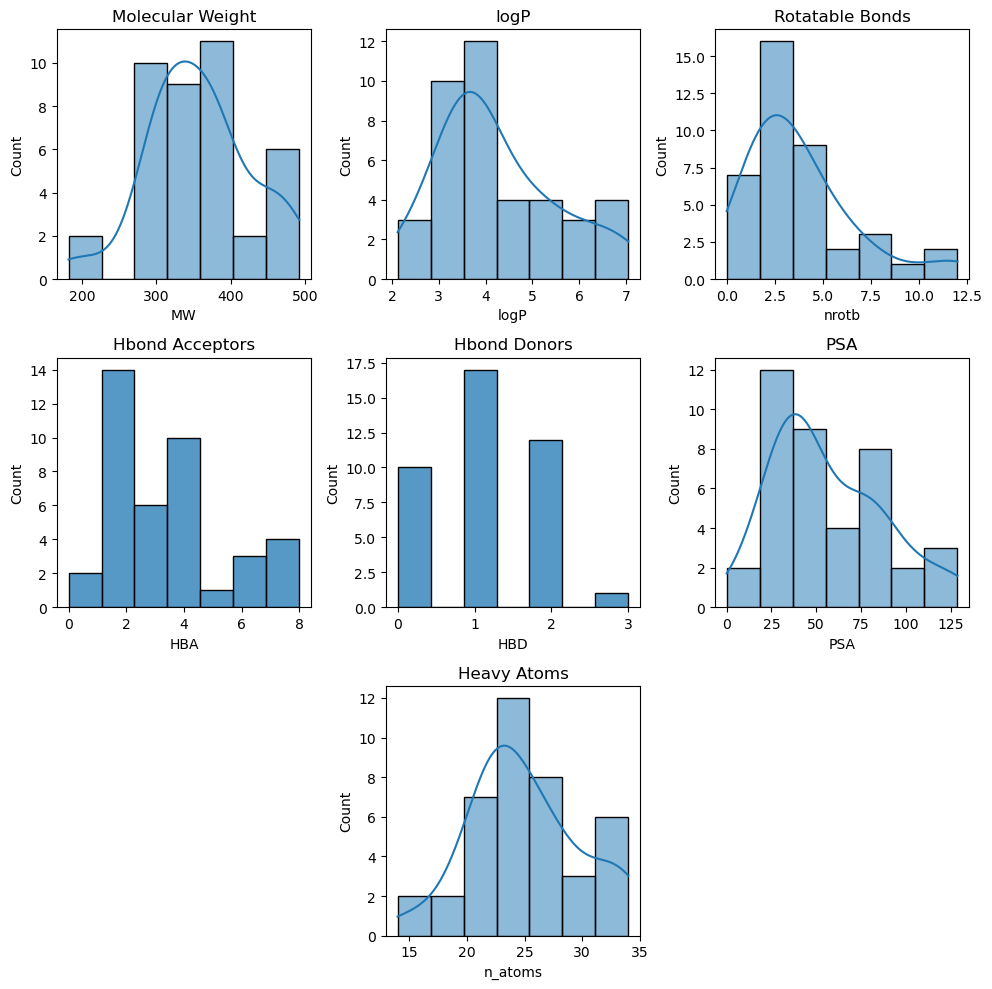

In [11]:
# We start by creating a figure containing a total of 9 subplots (3 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Next, we create histograms for the desired properties
# We can specify which subplot to fill using row and column indices of the axes
axes[0][0].set_title("Molecular Weight")
sns.histplot(data=information, x='MW', ax=axes[0,0], kde=True)

axes[0][1].set_title("logP")
sns.histplot(data=information, x='logP', ax=axes[0,1], kde=True)

axes[0][2].set_title("Rotatable Bonds")
sns.histplot(data=information, x='nrotb', ax=axes[0,2], kde=True)

axes[1][0].set_title("Hbond Acceptors")
sns.histplot(data=information, x='HBA', ax=axes[1,0])

axes[1][1].set_title("Hbond Donors")
sns.histplot(data=information, x='HBD', ax=axes[1,1])

axes[1][2].set_title("PSA")
sns.histplot(data=information, x='PSA', ax=axes[1,2], kde=True)

axes[2][1].set_title("Heavy Atoms")
sns.histplot(data=information, x='n_atoms', ax=axes[2,1], kde=True)

# We use tight_layout() to optimize the spacing between the subplots
fig.tight_layout()

# There are two extra subplots that we do not need, let's remove them
fig.delaxes(axes[2][0])
fig.delaxes(axes[2][2])

**Question 1:** Using the plotted information, what can you say about the compounds in the dataset? Keep in mind the Lipinsky rule of five.

## Prepare ligands

Next, we do not just have one ligand but a whole list of ligands. Since we only have the SMILES strings of the ligands, they need to be transformed to sdf files with a single conformation. In the following cells you find the already known functions.

**Task 1:** Define a function which converts SMILES codes to 3D conformation.

In [4]:
def generate_conformation(smiles, sanitize=True):
    """
    Convert a SMILES string to a conformation in 3D using a data-driven approach.

    Parameters
    ----------
    smiles: str
        SMILES string.
    sanitize: bool
        Sanitize the molecule by fixing small errors.
        
    Returns
    -------
    molecule: Chem.rdchem.Mol
        The generated conformer of the molecule
    """
    
    # Create a RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles, sanitize=sanitize)   
    molecule = Chem.AddHs(molecule)

    # Initiate the ETKD parameters of the third version
    params = AllChem.ETKDGv3()
    params.useSmallRingTorsions = True

    # Generate a single conformation with the given parameters   
    AllChem.EmbedMultipleConfs(molecule, numConfs = 1 , params = params)
    return molecule


def save_sdf(m: Chem.rdchem.Mol, target_path):
    """
    Saves mol as sdf file.
    
    Parameters
    ----------
    m: Chem.rdchem.Mol
        Compound to save
    target_path: str
        Path to save the compound to
    """
    sdf = Chem.SDWriter(target_path)
    sdf.write(m)

Before we start the conformer generation, we will define the output paths for the generated ligand conformers as well as the docked poses.

In [71]:
# Create all required folders
Path(path.join('output', 'ligands')).mkdir(parents=True, exist_ok=True)
Path(path.join('output', 'docked')).mkdir(parents=True, exist_ok=True)

# Save all the ligand paths in the pandas data frame, so we can keep track of our data
information["input_sdf"] = "output/ligands/" + information['Name'] + ".sdf"
information["docked_sdf"] = "output/docked/" + information['Name'] + ".sdf"

# Print the first few rows of the dataframe to check the output
information.head()

,Name,Affinity[µM],MW,logP,nrotb,HBA,HBD,PSA,n_atoms,Smiles,input_sdf,docked_sdf
0,9905296,0.001600,324.298,3.2207,3,3,1,45.33,23,O=c1cc(c2c([nH]1)cc1c(c2)N(CCO1)CC1CC1)C(F)(F)F,output/ligands/9905296.sdf,output/docked/9905296.sdf
1,D05,15.708427,284.393,5.0882,6,2,1,29.46,21,CC[C@@H]([C@H](c1ccc(cc1)O)CC)c1ccc(cc1)OC,output/ligands/D05.sdf,output/docked/D05.sdf
2,H09,22.019916,354.486,6.4955,3,0,0,0.00,19,ClC(C(c1ccc(cc1)Cl)c1ccc(cc1)Cl)(Cl)Cl,output/ligands/H09.sdf,output/docked/H09.sdf
3,23648052,0.243000,394.355,5.3518,7,2,1,36.10,27,O=c1[nH]c2ccc(cc2c(c1)C(F)(F)F)N(CC(F)(F)F)CCC...,output/ligands/23648052.sdf,output/docked/23648052.sdf
4,52944606,1.100000,456.614,5.1355,12,5,2,75.99,33,OC[C@H](COc1ccc(cc1C)C(c1ccc(c(c1)C)OCC(=O)C(C...,output/ligands/52944606.sdf,output/docked/52944606.sdf


Now, let's generate a 3D conformer for each ligand.

In [6]:
# Iterate through all molecules and generate conformation from SMILES code
for i, smi in tqdm(enumerate(information['Smiles']), total=len(information)):
    ligand_conformation = generate_conformation(smi)
    save_sdf(ligand_conformation, path.join('output','ligands', f'{information.iloc[i].Name}.sdf'))

  0%|          | 0/210 [00:00<?, ?it/s]

### Binding site definition

In theory, it would be possible to perform a docking calculation considering the whole protein as binding site. However, due to the known limitations of docking algorithms, it is always recommended to restrict the binding site to a certain region of interest to increase performance and accuracy. Here, we can use the coordinates of the co-crystallized ligand to define the binding site with a rectangular box. 


In [7]:
# The center of mass and box size has already been determined for you
pocket_center = [27.51935294, 1.65041176, 4.35223529]
pocket_size = [13.265, 15.134, 12.295]

## Docking calculation

Finally, we can proceed to the actual docking calculation. Smina is a command line tool, which currently does not provide a Python API. 

* However, we can write a function that will take care of generating the proper command and execute the calculation. 
* Besides providing the ligand, protein and pocket information, we can also alter the behavior of the docking calculation by setting the number of docking poses to be generated and by changing the exhaustiveness, which controls the number of independent docking calculations.

**Note:** Depending on the CPU speed and the docking settings this step may take a few minutes.

In [8]:
def run_smina(ligand, protein, output, pocket_center, pocket_size, num_poses=10, exhaustiveness=8):
    """
    Perform docking with Smina.

    Parameters
    ----------
    ligand: str or pathlib.Path
        Path to ligand file that should be docked. Formats: mol2, sdf, pdbqt, pdb
    protein: str or pathlib.Path
        Path to protein file that should be docked to. Formats: pdb, pdbqt
    output: str or pathlib.Path
        Path to which docking poses should be saved. Formats: sdf, mol2, pdb
    pocket_center: iterable of float or int
        Coordinates defining the center of the binding site.
    pocket_size: iterable of float or int
        Lengths of edges defining the binding site.
    num_poses: int
        Maximum number of poses to generate.
    exhaustiveness: int
        Accuracy of docking calculations.
        
        
    Here,  f"command {line} {arguments}".split() could also be used.
    Also, instead of pocket_center and pocket_size, the autobox
    function could be used.

    Returns
    -------
    output_text: str
        The output of the Smina calculation.
    """
    
    output_text = subprocess.check_output(
        [
            "smina",
            "--ligand",   ligand,
            "--receptor", protein,
            "--out",      output,
            "--center_x", str(pocket_center[0]),
            "--center_y", str(pocket_center[1]),
            "--center_z", str(pocket_center[2]),
            "--size_x",   str(pocket_size[0]),
            "--size_y",   str(pocket_size[1]),
            "--size_z",   str(pocket_size[2]),
            "--num_modes", str(num_poses),
            "--exhaustiveness", str(exhaustiveness),
        ],
        universal_newlines=True,  # needed to capture output text
    )
    return output_text

In [9]:
protein_path = path.join('input', "2AMB_receptor.pdb")

for i, molecule in tqdm(information.iterrows(), total=len(information)):
    run_smina(ligand=molecule['input_sdf'],
              protein=protein_path,
              output=molecule['docked_sdf'],
              pocket_center=pocket_center,
              pocket_size=pocket_size,
              )

  0%|          | 0/210 [00:00<?, ?it/s]

KeyboardInterrupt: 

The output is a file containing the docking poses and a text based description of the docking results including an estimated affinity and the root mean square deviation (RMSD) of each pose from the pose with the highest predicted affinity ([Vina output description](http://vina.scripps.edu/manual.html#output)).

## Docking results visualization

Now, let us analyze the docking results. Do the calculated docking scores agree with the experimentally determined binding affinities?

### Docking score statistics

To complete our dataframe, we will add the calculated docking scores for all ligands in the dataset. We can then use the generated data to analyze the results of the virtual screening.

In [72]:
def extract_docking_score(docked_molecule, pose_id=0):
    """
    Extract the docking score from an SDF file. The docking score
    is given under the "minimizedAffinity" property.

    Parameters
    ----------
    docked_molecule: str
        SDF file containing docking output.
    pose_id: int
        ID of pose to get the affinity of
        
    Returns
    -------
    score: float
        The calculated docking score
    """
    results=Chem.SDMolSupplier(docked_molecule, sanitize=False)
    score = float(results[pose_id].GetProp('minimizedAffinity'))
    return score

In [74]:
# Add the docking scores to the dataframe
# NOTE: The apply function takes the sdf path and hands it to the extract_docking_score function
# which returns the docking score and saves it in the dataframe.
information['score'] = information['docked_sdf'].apply(extract_docking_score)

# Before saving the final dataframe, let's sort the rows according to the docking score
information.sort_values('score', inplace=True)

# Write the dataframe to a csv file
information.to_csv('output/stats.csv')

# Print the first five elements of the final dataframe
information.head(10)

,Name,Affinity[µM],MW,logP,nrotb,HBA,HBD,PSA,n_atoms,Smiles,input_sdf,docked_sdf,score
38,25017761,0.062000,351.353,3.5034,3,4,1,81.53,26,CCOc1ccc2c(c1OC)c1ccc3c(c1c(=O)o2)c(C)cc(=O)[nH]3,output/ligands/25017761.sdf,output/docked/25017761.sdf,-11.21133
16,25016978,1.300000,309.316,2.8954,1,4,2,71.55,23,COc1cccc2c1-c1ccc3c(c1[C@H](O2)O)c(C)cc(=O)[nH]3,output/ligands/25016978.sdf,output/docked/25016978.sdf,-10.79634
36,44454392,0.053000,372.213,3.3341,1,4,0,46.61,23,O=C1[C@@H]2[C@H]3CC[C@@H]([C@@H]2C(=O)N1c1ccc(...,output/ligands/44454392.sdf,output/docked/44454392.sdf,-10.55456
20,9967148,0.001500,327.292,2.1759,2,6,1,106.67,24,O[C@@H]1CCN2[C@@H]1C(=O)N(C2=O)c1ccc(c2c1cccc2...,output/ligands/9967148.sdf,output/docked/9967148.sdf,-10.41095
12,A10,1.751567,290.440,3.6710,0,2,2,40.46,21,O[C@H]1CC[C@]2(C(=CC[C@@H]3[C@@H]2CC[C@]2([C@H...,output/ligands/A10.sdf,output/docked/A10.sdf,-9.88762
19,20587865,0.043000,310.314,3.9891,2,2,1,36.10,22,C[C@@H]1CC[C@H](N1c1ccc2c(c1)c(cc(=O)[nH]2)C(F...,output/ligands/20587865.sdf,output/docked/20587865.sdf,-9.80884
30,20587845,0.019000,310.314,3.9891,2,2,1,36.10,22,C[C@@H]1CC[C@@H](N1c1ccc2c(c1)c(cc(=O)[nH]2)C(...,output/ligands/20587845.sdf,output/docked/20587845.sdf,-9.66633
6,9841413,0.023000,352.351,3.9993,4,3,1,45.33,25,CC[C@H]1COc2c(N1CC1CC1)cc1c(c2)[nH]c(=O)cc1C(F...,output/ligands/9841413.sdf,output/docked/9841413.sdf,-9.65393
3,23648052,0.243000,394.355,5.3518,7,2,1,36.10,27,O=c1[nH]c2ccc(cc2c(c1)C(F)(F)F)N(CC(F)(F)F)CCC...,output/ligands/23648052.sdf,output/docked/23648052.sdf,-9.38002
29,9861044,0.001200,298.260,2.8306,2,3,1,45.33,21,CCN1CCOc2c1cc1c(c2)[nH]c(=O)cc1C(F)(F)F,output/ligands/9861044.sdf,output/docked/9861044.sdf,-9.32126


Now, we would like to get an estimate of the distribution of the docking scores. We will define an affinity threshold which should separate active compounds from inactive compounds.

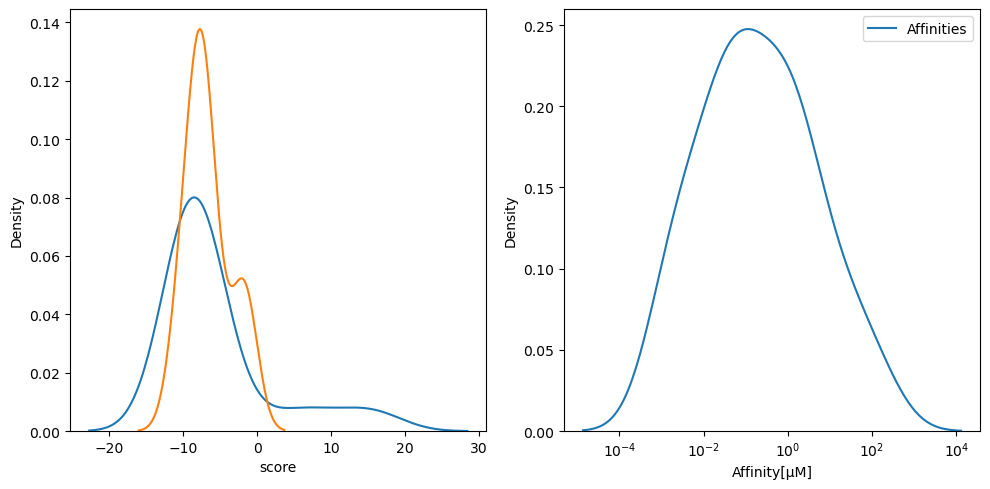

In [75]:
# Define affinity threshold (in µM)
affinity_threshold = 1.

# Define "active" and "inactive" compounds
actives = information[information['Affinity[µM]'] < affinity_threshold]
inactives = information[information['Affinity[µM]'] > affinity_threshold]

# Plot the densities of the scores
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].set(xscale="log")
sns.kdeplot(data=actives, x="score", label="Active", ax=axes[0])
sns.kdeplot(data=inactives, x="score", label="Inactive", ax=axes[0])
sns.kdeplot(data=information, x="Affinity[µM]", label="Affinities", ax=axes[1])
fig.tight_layout()

# Add a legend to the plot
plt.legend()

### ROC curve

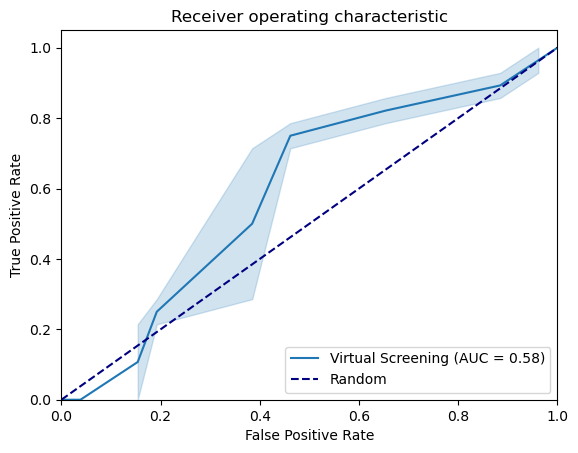

In [76]:
# Calculate TPR and FPR
(fpr, tpr, thresholds) = roc_curve(information['Affinity[µM]'] > affinity_threshold, information.score)

# Calculate the area under the curve
auroc = auc(fpr, tpr)

# Plot the ROC curve
sns.lineplot(x=fpr, y=tpr, label=f'Virtual Screening (AUC = {auroc:.2f})')

# Show random classifier
sns.lineplot(x=[0, 1], y=[0, 1], color="navy", linestyle="--", label='Random')

# Define limits of the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add axis labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Question 2:** Try adapting the affinity threshold. How does this affect the results and what does it mean?

Ideally, the calculated docking scores correlate with the measured affinity. Let's see if this is the case. We will analyze the results using an interactive plot.

In [119]:
# Add information about (in)activity to the dataframe
affinity_threshold = 1. # uM
information["active"] = (information['Affinity[µM]'] < affinity_threshold).astype('category')


# Create a figure using plotly
fig = px.scatter(
    information, 
    x="Affinity[µM]", 
    y="score",
    color='active'

)

# Add x-axis limits from 0 to 1
fig.update_xaxes(range=[0, 1])

# Use molplotly to draw an interactive plot
app = molplotly.add_molecules(
    fig=fig,
    df=information,
    smiles_col="Smiles",
    title_col="Name",
    color_col='active'
)

# Let's draw the interactive plot
app.run_server(mode='jupyterlab', port=8711, height=500)

/home/peter/tools/micromamba/envs/docking-test/lib/python3.11/site-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



**Question 3:** Investigate the outliers in the plot. Can you find an explanation why the calculated scores do not correlate with the measured affinity? Consider the 2D structures as well as the generated binding poses.

It looks like the correlation between the docking scores and the measured affinity is quite bad. Let's investigate more. To start, let us plot the docking score against the molecular weight.

In [125]:
# Create a figure using plotly
fig = px.scatter(
    information, 
    x="MW", 
    y="score",
    color='active'

)

# Use molplotly to draw an interactive plot
app = molplotly.add_molecules(
    fig=fig,
    df=information,
    smiles_col="Smiles",
    title_col="Name",
    color_col='active'
)

# Let's draw the interactive plot
app.run_server(mode='jupyterlab', port=8801, height=500)

/home/peter/tools/micromamba/envs/docking-test/lib/python3.11/site-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



It can be seen that the docking score increases (gets worse) with increasing molecular weight.

**Question 4:** What could be the reasons for this observation? Discuss possible reasons for the poor correlation between docking scores and measured affinities. Can you come up with ideas how to improve the results?